<h3 align="center">Observation and Circulation of Water Masses</h3>

___
<h1 align="center">Currents from Hydrology</h1>


___
<h2 align="center">Mario Herrero González </h2>


marioherreroglez34@gmail.com 

## Index

- [Libraries](#libs)
- [Introduction](#intro)
- [Question 1: N-S Transects](#q1)
- [Question 2: Potential Density Transect](#q2)
- [Question 3: $\Theta$ - $SA$ Diagram of Transect](#q3)
- [Question 4: Algorithm for geostrophic currents at given depth](#q5)
- [Question 5: Algorithm for surface currents](#q6)
- [Question 6: Map of surface currents](#q7)
- [Question 7: Sea Surface Currents from Altimetry](#q8)
- [Appendix 1: Data Preprocessing](#ap1)

<a name='libs'></a>
## Libraries

In [1]:
# import classical libraries
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gsw
from xgcm import Grid
from sklearn.metrics.pairwise import haversine_distances as hav
from math import radians

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
mpl.rcParams['figure.figsize'] = (20, 7)

In [ ]:
# Data preprocessing
temp = xr.open_dataset('woa18_decav_t00_01.nc',decode_times=False).drop(['time','climatology_bounds'])
sal = xr.open_dataset('woa18_decav_s00_01.nc',decode_times=False).drop(['time','climatology_bounds'])
nitr = xr.open_dataset('woa18_all_n00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
sili = xr.open_dataset('woa18_all_i00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
phos = xr.open_dataset('woa18_all_p00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
oxyg = xr.open_dataset('woa18_all_o00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
names = ['t_an', 's_an', 'n_an', 'i_an', 'p_an','o_an']
dr = xr.merge([temp, sal, nitr, sili, phos, oxyg])[names]
dr = dr.assign_coords(lon=(dr.lon % 360)).roll(lon=(dr.dims['lon'] // 2),roll_coords=True)

lon_E, lon_W = 110, 200
lat_S, lat_N=-60, 70
dr = dr.where((dr.lon>lon_E)&(dr.lon<290),drop=True)
dr = dr.where((sal.lat>=lat_S)&(sal.lat<=lat_N),drop=True)

#Uncomment the following line in order to save the dataset
dr.to_netcdf('pacific.nc')

<a name='intro'></a>
## Introduction

The basin here studied is the Pacific Ocean Basin. Its principal currents and gyres are shown in Fig. 1. This region is given by:

\begin{equation}
\theta \in (-130º, 70º)
\end{equation}
\begin{equation}
\lambda \in (-60º, 70º)
\end{equation}

<a href='https://i.stack.imgur.com/0UEcB.png'><p style="text-align:center;"> <img src=" 
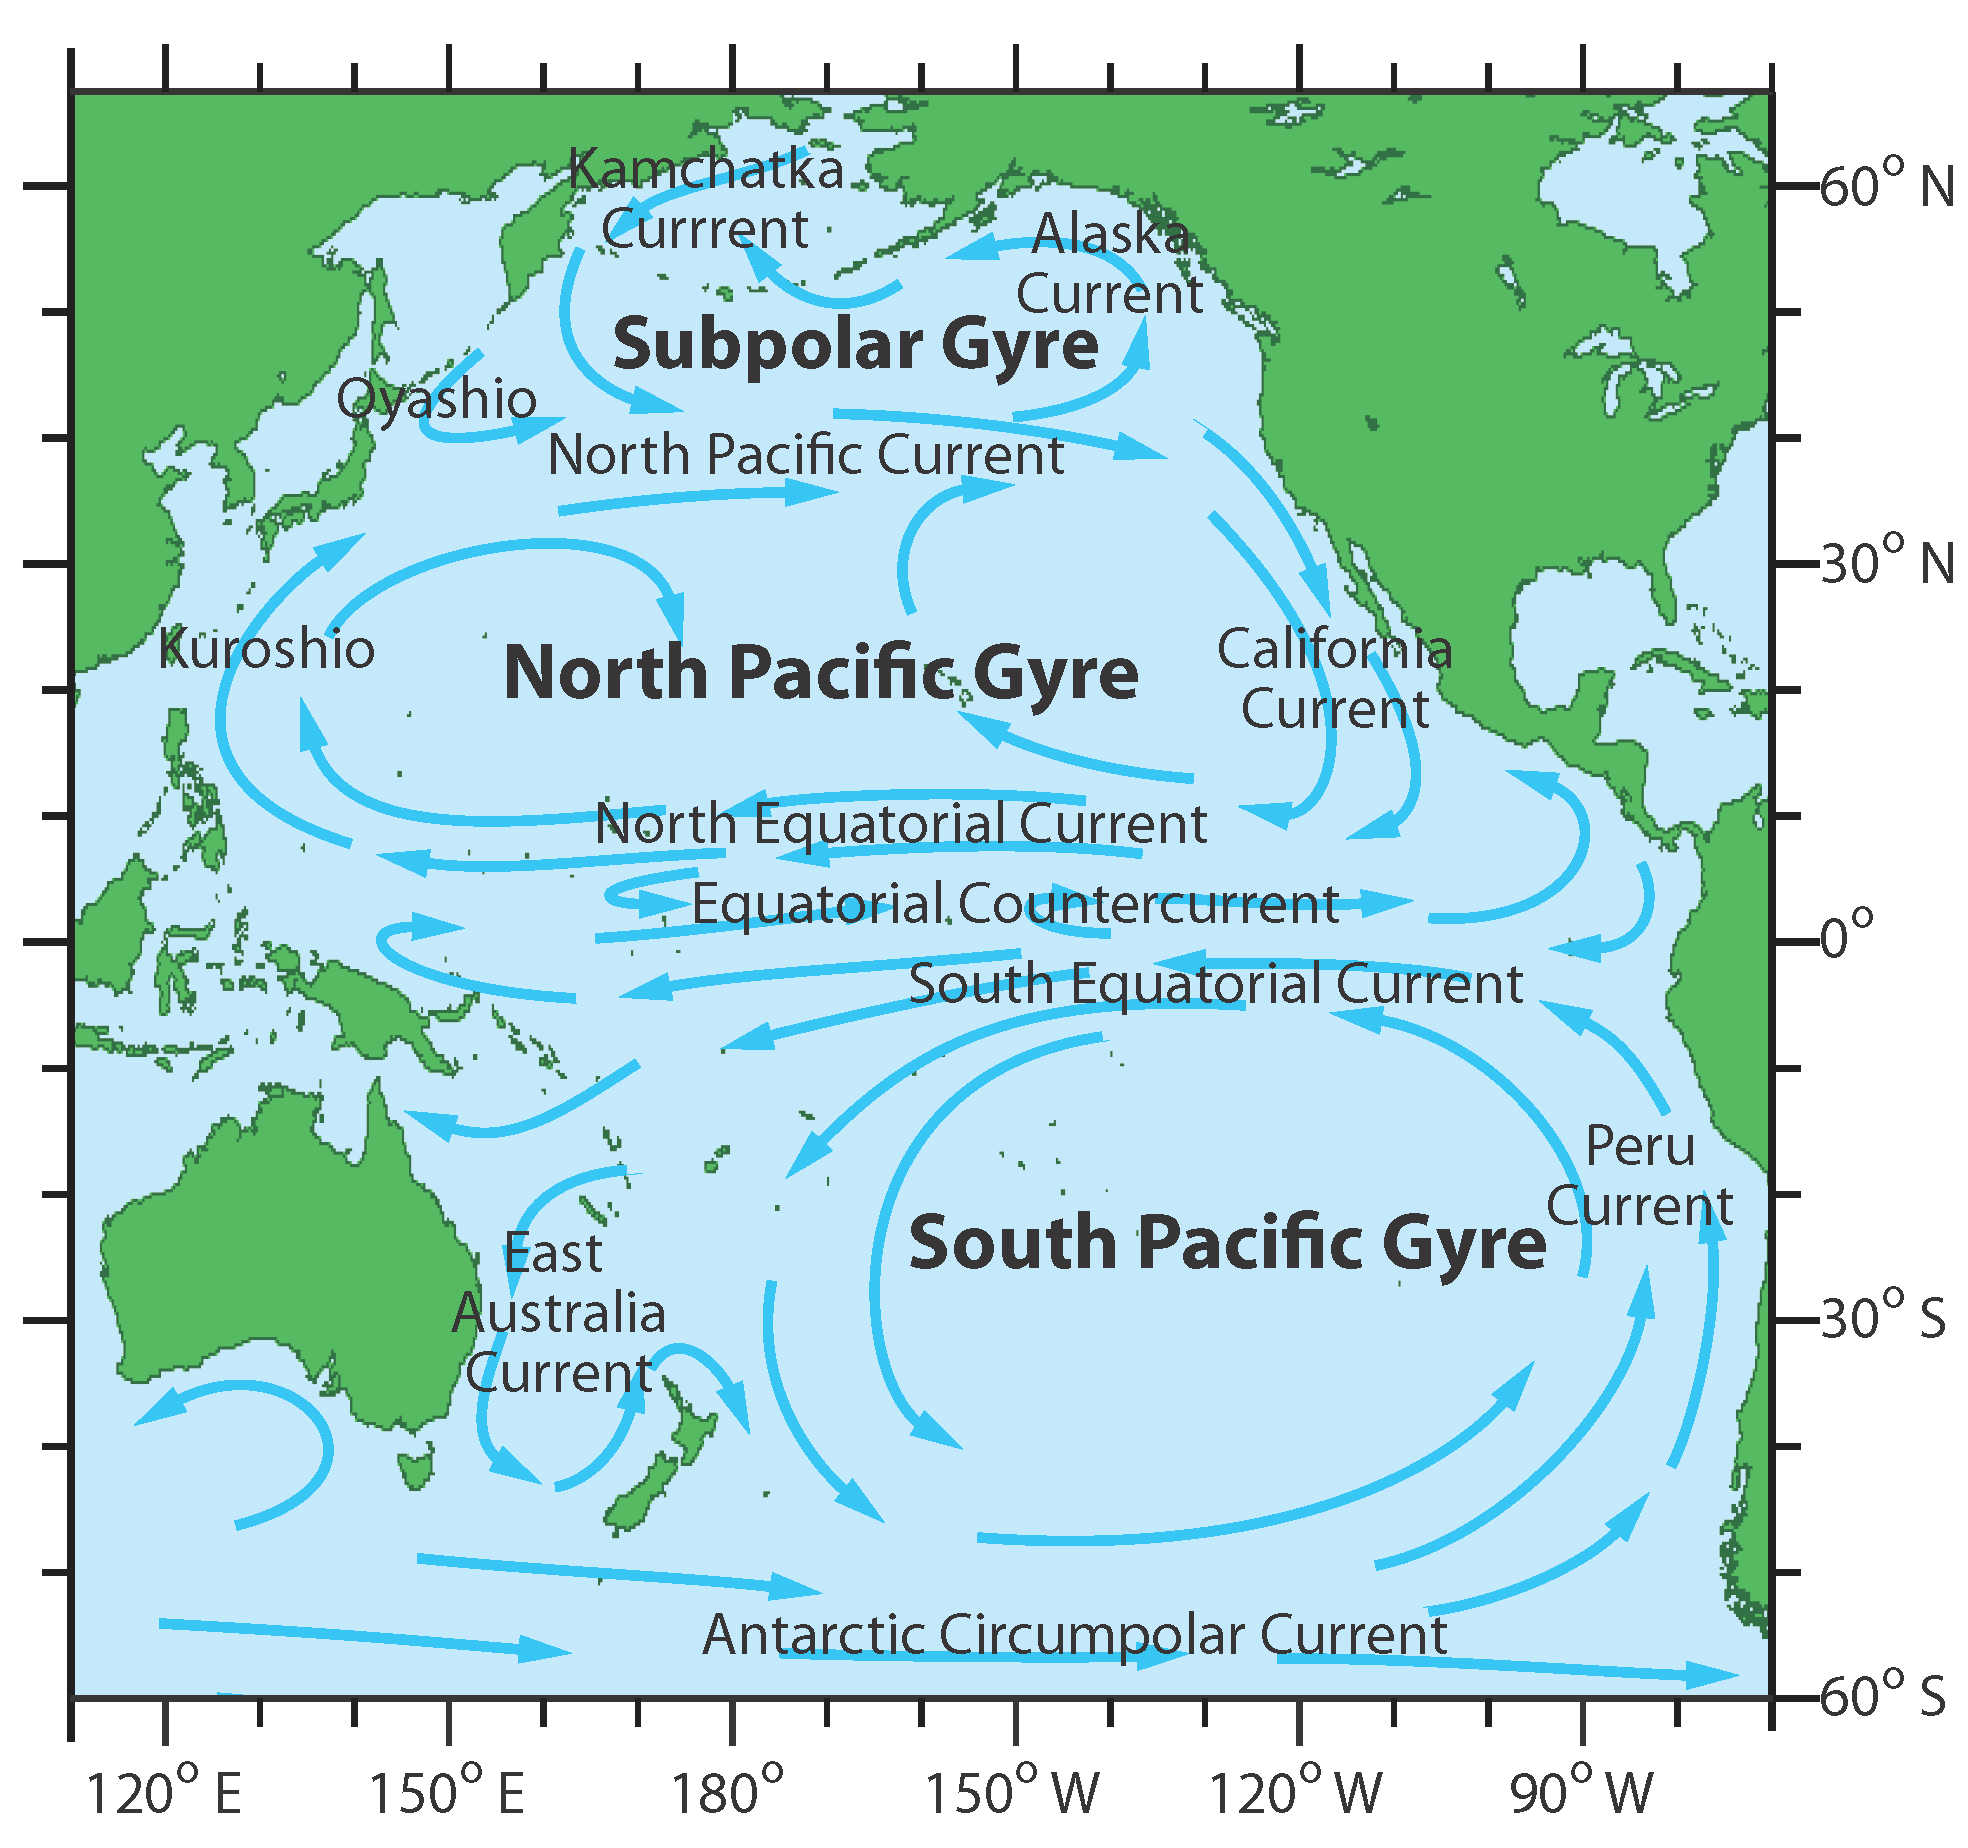
" class="center"/></a>

<center>  Figure 1: Pacific ocean basin with principal currents and gyres</center>

Libraries are imported:

Data is read. The file used is a pretreated version of the original dataset. The treatment can be found in [Appendix 1](#ap1).

*NB:* As the study is for the Pacific Ocean basin, the longitude coordinate has been rolled to a 0º to 360º system. This enables to adjust the coordinate system of the data so it is centered over the anti-meridian instead.

In [2]:
ds = xr.open_dataset('pacific.nc')
ds['depth'] = -ds['depth']

<a name='q1'></a>
## Question 1: N-S Transects

In [3]:
ds['P'] = gsw.p_from_z(ds.depth, ds.lat).expand_dims({'lon' : ds.lon}).where(ds['t_an'] == ds['t_an'])
ds['SA'] = gsw.SA_from_SP(ds.s_an,ds.P,ds.lon,ds.lat)
ds['CT'] = gsw.CT_from_t(ds.SA, ds.t_an, ds.P)


In [4]:
ds

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 130, lon: 180, time: 1)
Coordinates:
  * lat      (lat) float32 -59.5 -58.5 -57.5 -56.5 -55.5 ... 66.5 67.5 68.5 69.5
  * lon      (lon) float32 110.5 111.5 112.5 113.5 ... 286.5 287.5 288.5 289.5
  * depth    (depth) float32 -0.0 -5.0 -10.0 ... -5.3e+03 -5.4e+03 -5.5e+03
Dimensions without coordinates: time
Data variables:
    t_an     (time, depth, lat, lon) float32 ...
    s_an     (time, depth, lat, lon) float32 ...
    n_an     (time, depth, lat, lon) float32 ...
    i_an     (time, depth, lat, lon) float32 ...
    p_an     (time, depth, lat, lon) float32 ...
    o_an     (time, depth, lat, lon) float32 ...
    P        (lon, depth, lat, time) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    SA       (time, depth, lat, lon) float64 34.07 34.07 34.07 ... nan nan nan
    CT       (time, depth, lat, lon) float64 0.634 0.6808 0.7215 ... nan nan nan
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

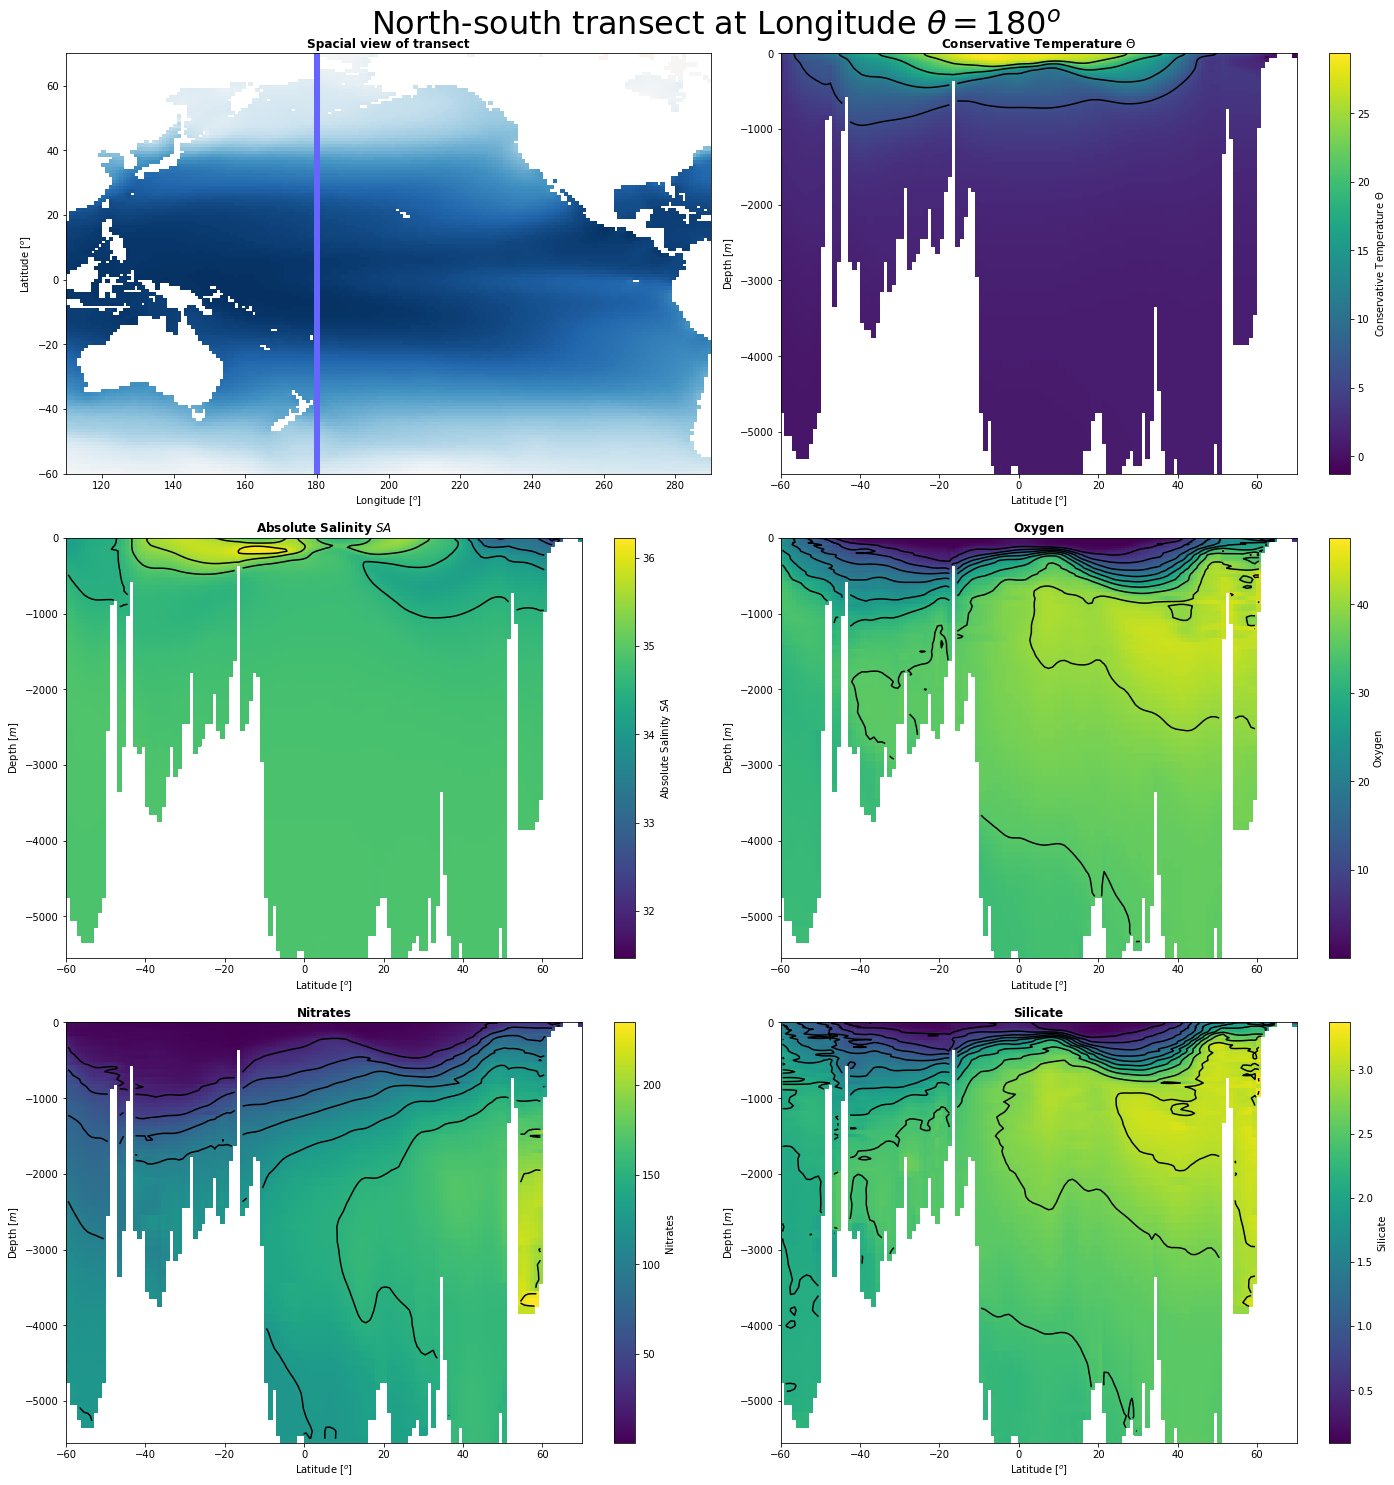

In [5]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(20,21))
fig.suptitle(r'North-south transect at Longitude $\theta=180^o$', fontsize=32)
# Plotting location of chosen transect as red line
variable = ds.CT.isel(depth=0)
variable.plot(ax=axes[0,0],add_colorbar=False, cmap='RdBu')
axes[0,0].axvline(x=180, c='#6666ff',lw=6)
axes[0,0].set_title('Spacial view of transect',fontweight="bold")
axes[0,0].set_ylabel(r'Latitude [$^o$]')
axes[0,0].set_xlabel(r'Longitude [$^o$]')
#axes[0,0].colorbar()

# Plotting the transects
count = 0
titles = [r'Conservative Temperature $\Theta$', r'Absolute Salinity $SA$',
         'Oxygen', 'Nitrates', 'Silicate', 'Phosphate']
names = ['CT', 'SA', 'n_an', 'i_an', 'p_an','o_an']
variable = ds[names[count]].sel(lon=180,method='nearest')

variable.plot(ax=axes[0,1],
                  cbar_kwargs={'label':titles[count]},
                        vmin=variable.min(), vmax=variable.max())

variable[0].plot.contour(ax=axes[0,1],cmap='k', levels=12)
axes[0,1].set_xlabel(r'Latitude [$^o$]')
axes[0,1].set_ylabel(r'Depth [$m$]')
axes[0,1].set_title(titles[count],fontweight="bold")


for i in range(1,axes.shape[0]):
    for j in range(axes.shape[1]):
        count += 1
        variable = ds[names[count]].sel(lon=180,method='nearest')
        variable.plot(ax=axes[i,j], cbar_kwargs={'label':titles[count]},
                        vmin=variable.min(), vmax=variable.max())
        variable[0].plot.contour(ax=axes[i,j],cmap='k', levels=12)
        axes[i,j].set_xlabel(r'Latitude [$^o$]')
        axes[i,j].set_ylabel(r'Depth [$m$]')
        axes[i,j].set_title(titles[count],fontweight="bold")
        
plt.tight_layout()

<a name='q2'></a>
## Question 2: Potential Density Transect

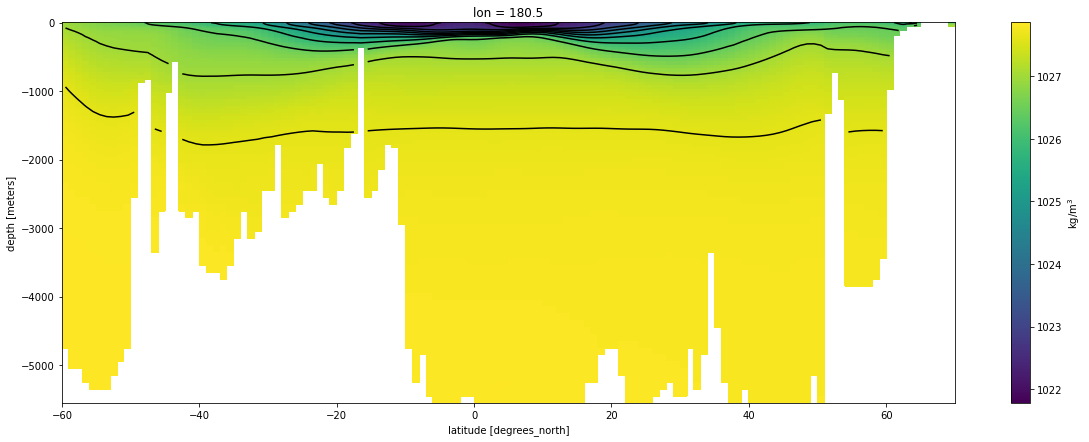

In [6]:
ds['rho_pot'] = gsw.rho_t_exact(ds.SA, ds.CT, 0)
variable = ds.rho_pot.sel(lon=180,method='nearest')
variable.plot(cbar_kwargs={'label':r'kg/m$^3$'},
                        vmin=variable.min(), vmax=variable.max(),)
variable[0].plot.contour(cmap='k', levels=12,)

<a name='q3'></a>
## Question 3: $\Theta$ - $SA$ Diagram of Transect, and Major Water Masses

Ref [Emery Et Al.](https://archimer.ifremer.fr/doc/00110/22090/19731.pdf)

### Upper waters (0 - 500 m)

<a href='https://archimer.ifremer.fr/doc/00110/22090/19731.pdf'><p style="text-align:center;"> <img src=" 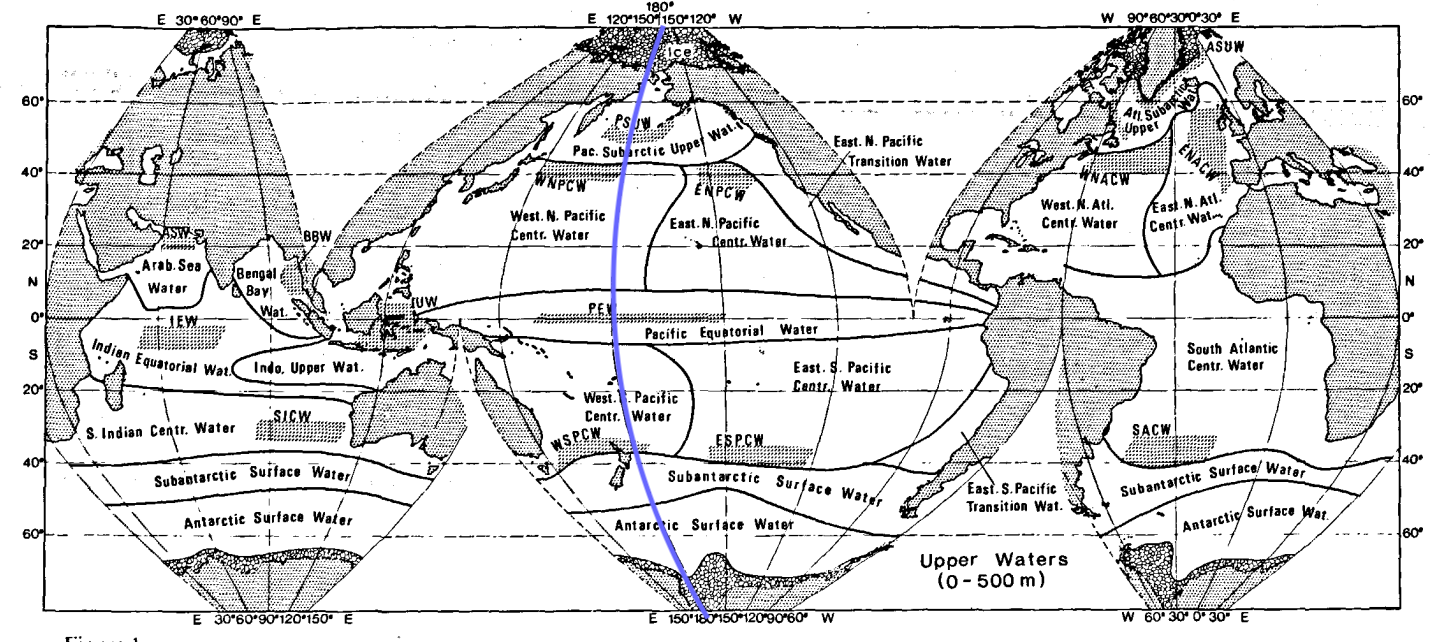 " class="center"/></a>
<center>  Figure 2: Global distribution of upper waters (0 - 500 m). Water masses are labelled in abbreviatedform with their boundaries indicated by solid lines. Formation regions for these water masses are marked by cross hatching and labelled with the corresponding acronym title. </center>

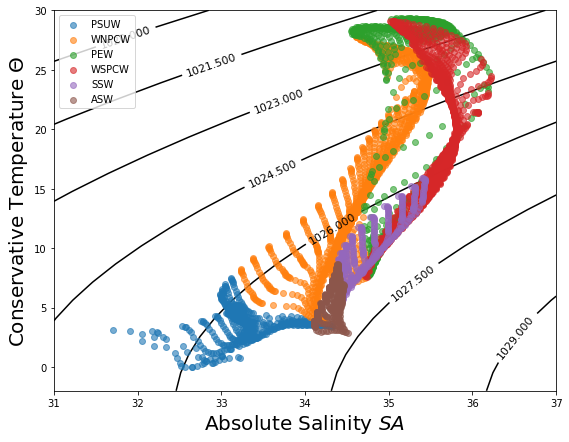

In [7]:
depth_min = -500
depth_max = 0
depth_cond = (ds.depth>= depth_min) & (ds.depth <= depth_max)
plt.figure(figsize=(9,7))
names = ['PSUW', 'WNPCW', 'PEW','WSPCW','SSW','ASW']
latitudes = [65,46,10,-10,-40,-50,-65]
longitude = 180
for i, name in enumerate(names):
    lat_cond = (ds.lat >= latitudes[i+1]) & (ds.lat < latitudes[i])
    ds['CT_'+ name] = ds.CT.sel(lon=longitude, method = 'nearest').where(depth_cond).where(lat_cond)
    ds['SA_'+ name] = ds.SA.sel(lon=longitude, method = 'nearest').where(depth_cond).where(lat_cond)

    xr.plot.scatter(ds, 'SA_'+name, 'CT_'+name,zorder=2,label = name,alpha=0.6)

    
ds['CT_upper'] = ds.CT.sel(lon=longitude, method = 'nearest').where(depth_cond)
ds['SA_upper'] = ds.SA.sel(lon=longitude, method = 'nearest').where(depth_cond)
    
x_SA = np.linspace(xr.ufuncs.floor(ds['SA_upper'].min()),xr.ufuncs.ceil(ds['SA_upper'].max()),22)
y_CT = np.linspace(xr.ufuncs.floor(ds['CT_upper'].min()),xr.ufuncs.ceil(ds['CT_upper'].max()),22)
rho_pot = gsw.pot_rho_t_exact(*np.meshgrid(x_SA,y_CT),p=0, p_ref=0)
cp = plt.contour(x_SA,y_CT,rho_pot,zorder=1,colors='k')
plt.clabel(cp, fontsize=11, inline=1)

plt.xlabel('Absolute Salinity $SA$', fontsize = 20)
plt.ylabel(r'Conservative Temperature $\Theta$', fontsize = 20)

plt.legend()

NB: The labels definitions can be found in Figure 2.

### Intermediate waters (500 - 1500 m)

<a href='https://archimer.ifremer.fr/doc/00110/22090/19731.pdf'><p style="text-align:center;"> <img src=" 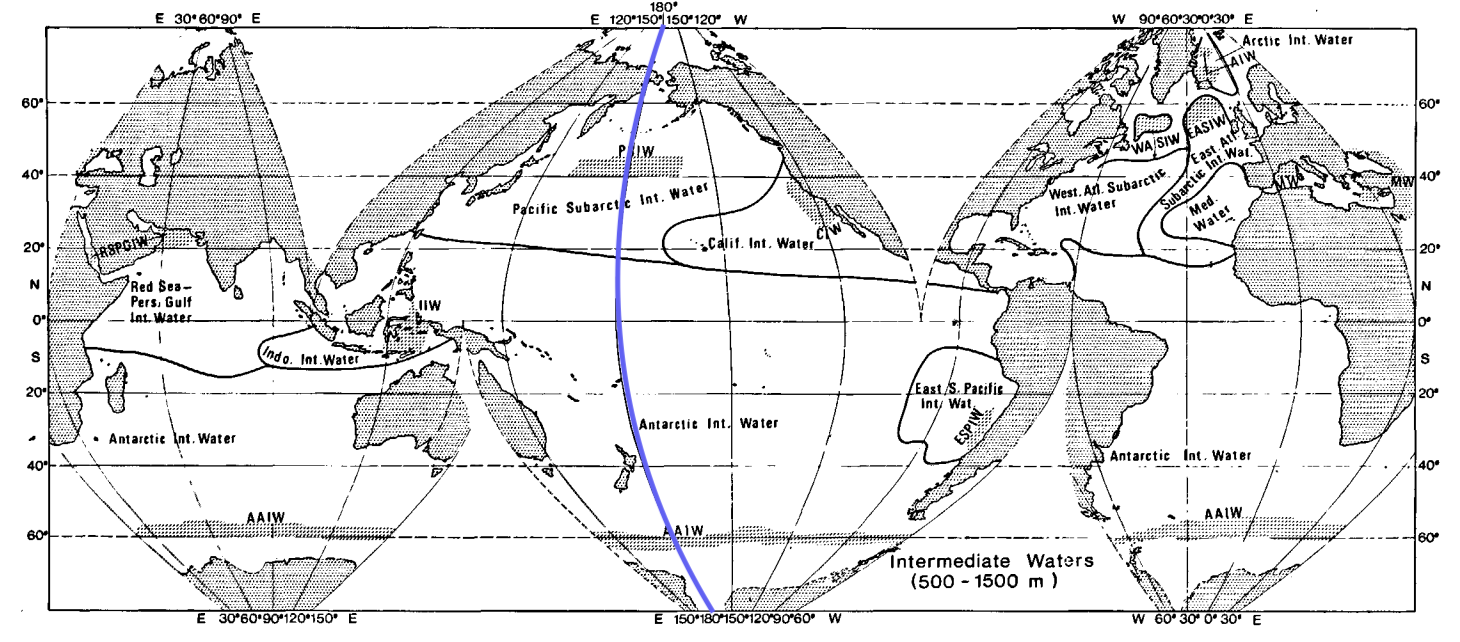 " class="center"/></a>
<center>  Figure 3: Global distribution of intermediate waters (500 - 1500 m). Water masses are labelled in abbreviated form with their boundaries indicated by solid lines. Formation regions for these water masses are marked by cross hatching and labelled with the corresponding acronym title. </center>

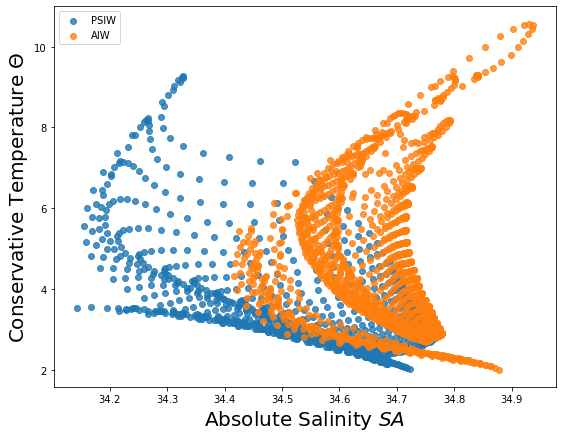

In [8]:
depth_min = -1500
depth_max = -500
depth_cond = (ds.depth>= depth_min) & (ds.depth <= depth_max)
plt.figure(figsize=(9,7))
names = ['PSIW','AIW']
latitudes = [65,15,-65]
longitude = 180
for i, name in enumerate(names):
    lat_cond = (ds.lat >= latitudes[i+1]) & (ds.lat < latitudes[i])
    ds['CT_'+ name] = ds.CT.sel(lon=longitude, method = 'nearest').where(depth_cond).where(lat_cond)
    ds['SA_'+ name] = ds.SA.sel(lon=longitude, method = 'nearest').where(depth_cond).where(lat_cond)

    xr.plot.scatter(ds, 'SA_'+name, 'CT_'+name,zorder=2,label = name,alpha = 0.8)

    
ds['CT_intermediate'] = ds.CT.sel(lon=longitude, method = 'nearest').where(depth_cond)
ds['SA_intermediate'] = ds.SA.sel(lon=longitude, method = 'nearest').where(depth_cond)

x_SA = np.linspace(xr.ufuncs.floor(ds['SA_intermediate'].min()),xr.ufuncs.ceil(ds['SA_intermediate'].max()))
x_CT = np.linspace(xr.ufuncs.floor(ds['CT_intermediate'].min()),xr.ufuncs.ceil(ds['CT_intermediate'].max()))
rho_pot = gsw.pot_rho_t_exact(*np.meshgrid(x_SA,y_CT),p=0, p_ref=0)
#cp = plt.contour(x_SA,y_CT,rho_pot,zorder=1,colors='k',)
#plt.clabel(cp, fontsize=11, inline=1)

plt.xlabel('Absolute Salinity $SA$', fontsize = 20)
plt.ylabel(r'Conservative Temperature $\Theta$', fontsize = 20)
#plt.ylim([0,11])
plt.legend()

### Deep and abyssal waters (1500 m - bottom)

<a href='https://archimer.ifremer.fr/doc/00110/22090/19731.pdf'><p style="text-align:center;"> <img src=" 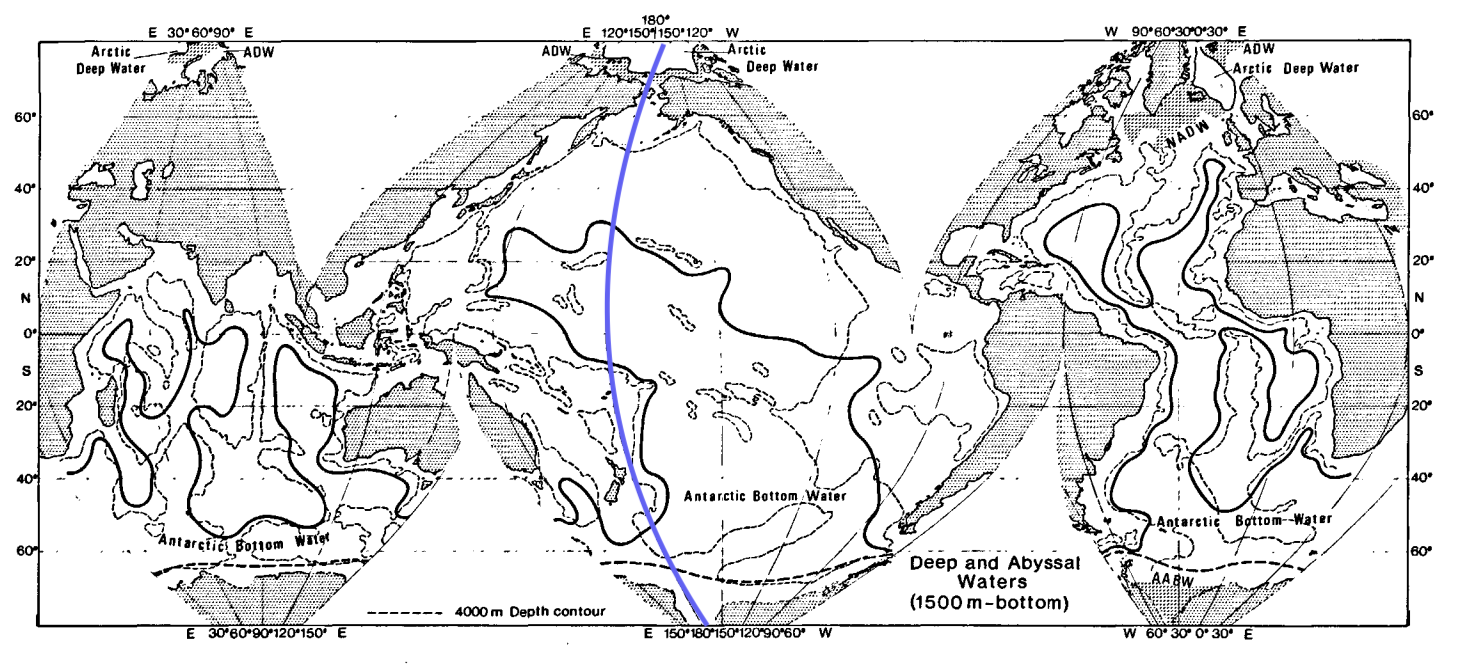 " class="center"/></a>
<center>  Figure 4: Global distribution of deep and abyssal waters (1500 m - bottom). Water masses are labelled in abbreviated form with their boundaries indicated by solid lines. Formation regions for these water masses are marked by cross hatching and labelled with the corresponding acronym title. </center>

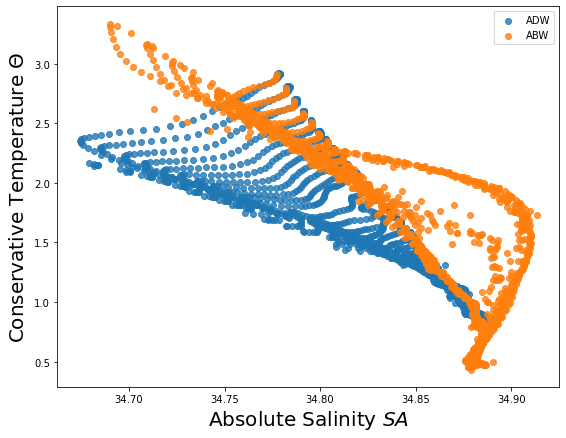

In [9]:
depth_min = -11000
depth_max = -1500
depth_cond = (ds.depth>= depth_min) & (ds.depth <= depth_max)
plt.figure(figsize=(9,7))
names = ['ADW','ABW']
latitudes = [65,0,-65]
longitude = 180
for i, name in enumerate(names):
    lat_cond = (ds.lat >= latitudes[i+1]) & (ds.lat < latitudes[i])
    ds['CT_'+ name] = ds.CT.sel(lon=longitude, method = 'nearest').where(depth_cond).where(lat_cond)
    ds['SA_'+ name] = ds.SA.sel(lon=longitude, method = 'nearest').where(depth_cond).where(lat_cond)

    xr.plot.scatter(ds, 'SA_'+name, 'CT_'+name,zorder=2,label = name,alpha = 0.8)

    
ds['CT_bottom'] = ds.CT.sel(lon=longitude, method = 'nearest').where(depth_cond)
ds['SA_bottom'] = ds.SA.sel(lon=longitude, method = 'nearest').where(depth_cond)

x_SA = np.linspace(xr.ufuncs.floor(ds['SA_bottom'].min()),xr.ufuncs.ceil(ds['SA_bottom'].max()))
x_CT = np.linspace(xr.ufuncs.floor(ds['CT_bottom'].min()),xr.ufuncs.ceil(ds['CT_bottom'].max()))
rho_pot = gsw.pot_rho_t_exact(*np.meshgrid(x_SA,y_CT),p=0, p_ref=0)


plt.xlabel('Absolute Salinity $SA$', fontsize = 20)
plt.ylabel(r'Conservative Temperature $\Theta$', fontsize = 20)

plt.legend()

<a name='q5'></a>
## Question 5: Algorithm for geostrophic currents at given depth

### Theory
The Geostrophic equations provide a means for determining current velocities from the pressure field $p$ which is related to the distribution of density in the ocean,

\begin{equation}
u = -\frac{1}{f\rho}\frac{\partial p}{\partial y} \quad v = \frac{1}{f\rho}\frac{\partial p}{\partial x}.
\end{equation}

The pressure field can be given on a series of level surfaces (with respect to the earth's geopotential surfaces).

\begin{equation}
\frac{dp}{dz} = \rho g \implies \frac{1}{\rho} dp = gdz = dD
\end{equation}
$D$ is the geopotential height.

Then,

\begin{equation}
u=-\frac{1}{f}\frac{\partial D}{\partial y} \quad v = \frac{1}{f}\frac{\partial D}{\partial x}
\end{equation}

By defining $\alpha = \frac{1}{\rho}$ as the specific volume, one can define the geopotential height between two equal pressure surfaces $p_1$ and $p_2$ at two different hydrographic stations $a$ and $b$ in the east/west direction,

\begin{equation}
D_a - D_b = \int_{p_1}^{p_2}(\alpha_a - \alpha_b)dp.
\end{equation}.

Giving therefore the slope between two surfaces at constant pressure
\begin{equation}
\frac{D_a-D_b}{\Delta X}
\end{equation}
This results in the $v$-component of the geostrophic velocity shear,

\begin{equation}
v = \frac{1}{f}\frac{D_a-D_b}{\Delta X}.
\end{equation}

By choosing two stations, $a$ and $c$, in the north/south direction the $u$-component of the geostrophic velocity shear is found,
\begin{equation}
u = -\frac{1}{f}\frac{D_a-D_c}{\Delta Y}.
\end{equation}

## Algorithm

1. Select a reference pressure level ($z$ ~ -1500 m) where $\nabla p = 0$ $\implies$ no velocity, $u, v = 0$ $\implies$ $D_a - D_b = 0$ and $D_a - D_c$ = 0.
2. As the velocity components are calculated in the cell's face, longitude, latitude, pressure and specific volume anomaly should be also given in the cell's face.
3. $D_a - D_b$ and $D_a - D_c$ are then calculated with a cumulative sum (i.e. integration) at the desired pressure level.
4. Calculate $\Delta X$ and $\Delta Y$ given by the distance between cell faces.
5. Calculate the Coriolis parameter $f$ at cell faces.
6. Compute $u$ and $v$. 

<a name='q6'></a>
## Question 6: Algorithm for surface currents

In [10]:
# Calculate values at faces
    # Longitude, Latitude and depth
ds['lat_i'] = np.arange(ds.lat.min()+np.diff(ds.lat)[0]/2, ds.lat.max()+np.diff(ds.lat)[-1]/2)
ds['lon_i'] = np.arange(ds.lon.min()+np.diff(ds.lon)[0]/2, ds.lon.max()+np.diff(ds.lon)[-1]/2)
ds['depth_i'] = ds.depth[:-1].values + np.diff(ds.depth)/2

ds = ds.rename_dims({
        'lon':'lon_c', 'lat':'lat_c', 'depth':'depth_c'
    }).rename_vars({
        'lon':'lon_c','lat':'lat_c', 'depth':'depth_c'
    })

    # Setting a grid at the faces
grid = Grid(ds, coords={"lon": {"center": "lon_c", "inner": "lon_i"}, 
                        "lat": {"center": "lat_c", "inner": "lat_i"},
                        "depth" :{"center": "depth_c", "inner": "depth_i"}},
            periodic=False,boundary='extend')

In [11]:
#Specific volume anomaly
ds['alpha'] = gsw.specvol(ds.SA, ds.CT, ds.P) # at cell centers
ds['anom'] = grid.diff(ds.alpha, axis=['lon','lat']) # at faces
    # Pressure at faces
ds['P_i'] = grid.interp(ds.P, axis=['depth','lon','lat'])
ds['dP'] = grid.diff(ds.P_i, axis='depth') 
    # Calculating at faces

# Defining Delta X and Delta Y
ds['dist_x'] =  ['lon_i','lat_i'],np.zeros((ds.lon_i.size,ds.lat_i.size)),
for j in range(ds.lat_i.size):
    for i in range(ds.lon_i.size):
        ds['dist_x'][i,j]=hav([[ds.lat_c[j],ds.lon_c[i]],
                            [ds.lat_c[j],ds.lon_c[i+1]]])[1,0]
        
ds['dist_y'] =  ['lon_i','lat_i'],np.zeros((ds.lon_i.size,ds.lat_i.size)),
for j in range(ds.lat_i.size):
    for i in range(ds.lon_i.size):
        ds['dist_y'][i,j]=hav([[ds.lat_c[j],ds.lon_c[i]],
                            [ds.lat_c[j+1],ds.lon_c[i]]])[1,0]        
R = 6371000 #m
ds['dist_x'] = R*ds['dist_x']
ds['dist_y'] = R*ds['dist_y']


# Defining Coriolis
ds['f_i'] = 2*np.pi/(24*3600)*np.sin(ds.lat_i*np.pi/180)

In [12]:
#ds['vec_U'] = ().sum(axis=1)
ref = ds.depth_c>=-1500 # so it coincides with face level
ds['D'] = (ds.anom.where(ref) *  -ds.dP.where(ref)).sum(axis=1) # Pressure greater at the bottom
ds['u'] = - ds['D']/ds['dist_x']/ds['f_i']*1e4
ds['v'] =  ds['D']/ds['dist_y']/ds['f_i']*1e4


<a name='q7'></a>
## Question 7: Map of surface currents

Text(0.5, 1.0, 'Integrated velocity field for the Pacific Ocean')

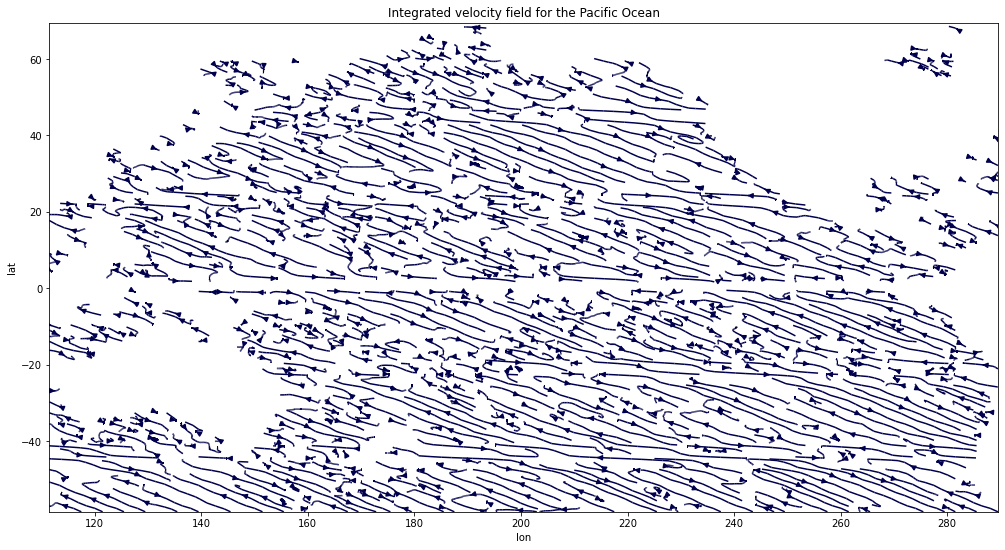

In [13]:
fig, ax = plt.subplots(figsize=(17,9))
x, y = ds.lon_c.values[1:],ds.lat_c.values[1:]
(u, v) = ds.u.values[0], ds.v.values[0]
sp = ax.streamplot(x, y, u, v,
                  color='#00004d',
                  density=3)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_title('Integrated velocity field for the Pacific Ocean')

<a name='q8'></a>
## Question 8: Sea Surface Currents from Altimetry

In [14]:
alt = xr.open_dataset('altimetry.nc')

In [15]:
alt

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2016-11-30
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
Data variables:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    ugos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2016-11-30T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2016-11-30T00:00:00Z
    title:                           DT all-sat-merged Global Ocean Gridded S...

In [16]:
lon_E, lon_W = 110, 200
lat_S, lat_N=-60, 70
alt = alt.where((alt.longitude>lon_E)&(alt.longitude<290),drop=True).drop(['time','nv'])

Text(0.5, 1.0, 'Altimetry velocity field for the Pacific Ocean')

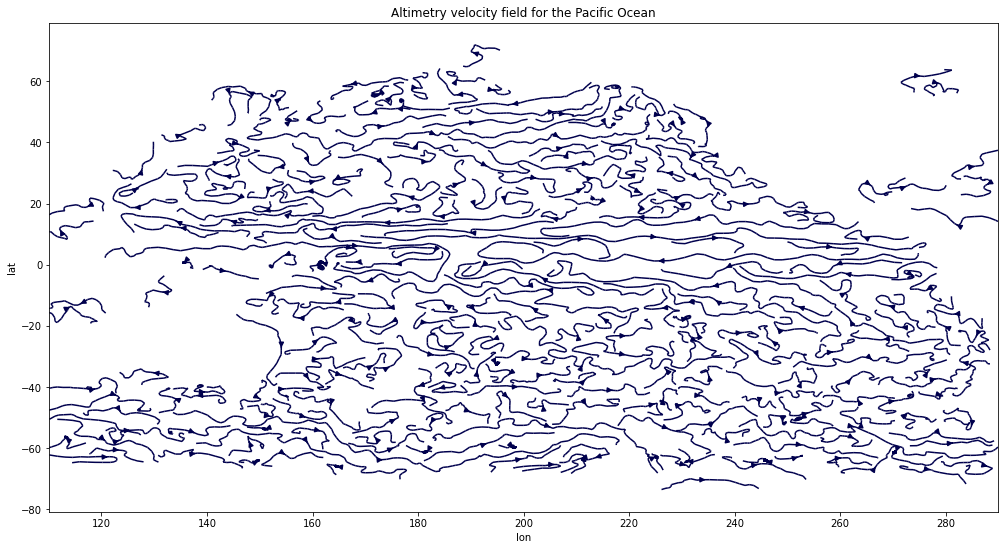

In [17]:
fig, ax = plt.subplots(figsize=(17,9))
x, y = alt.longitude.values,alt.latitude.values
(u, v) = alt.ugos.values[0], alt.vgos.values[0]
sp = ax.streamplot(x, y, u, v,
                  color='#00004d',
                  density=4)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_title('Altimetry velocity field for the Pacific Ocean')

The altimetry data has a greater resolution and therefore currents are much smoother. Nevertheless in both cases it is easy to distinguish the equatorial current and the North and South gyre

<a name='ap1'></a>
## Appendix 1: Data Preprocessing

In [ ]:
temp = xr.open_dataset('woa18_decav_t00_01.nc',decode_times=False).drop(['time','climatology_bounds'])
sal = xr.open_dataset('woa18_decav_s00_01.nc',decode_times=False).drop(['time','climatology_bounds'])
nitr = xr.open_dataset('woa18_all_n00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
sili = xr.open_dataset('woa18_all_i00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
phos = xr.open_dataset('woa18_all_p00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
oxyg = xr.open_dataset('woa18_all_o00_01.nc', decode_times=False).drop(['time','climatology_bounds'])
names = ['t_an', 's_an', 'n_an', 'i_an', 'p_an','o_an']
dr = xr.merge([temp, sal, nitr, sili, phos, oxyg])[names]
dr = dr.assign_coords(lon=(dr.lon % 360)).roll(lon=(dr.dims['lon'] // 2),roll_coords=True)

lon_E, lon_W = 110, 200
lat_S, lat_N=-60, 70
dr = dr.where((dr.lon>lon_E)&(dr.lon<290),drop=True)
dr = dr.where((sal.lat>=lat_S)&(sal.lat<=lat_N),drop=True)

#Uncomment the following line in order to save the dataset
#dr.to_netcdf('pacific.nc')